
## Sesión 4
**Aprendizaje por Refuerzo en entornos discretos G16**  
*Inteligencia Artificial I*

### Ejemplo 3. CliffWalking  (para entregar) 

Para esta práctica se pide entrenar y analizar en detalle el comportamiento de un agente para el problema CliffWalking (y/o BlackJack).
Puedes encontrar más información en la documentación de Gymnasium:
[https://gymnasium.farama.org/environments/toy_text/cliff_walking/]

El juego comienza con el jugador en la ubicación (3, 0) de una cuadrícula de 4x12, con el objetivo situado en (3, 11). Si el jugador llega al objetivo, el episodio termina.
Un precipicio se extiende a lo largo de (3, 1..10). Si el jugador se mueve a una ubicación del precipicio, vuelve al punto de inicio.

El jugador realiza movimientos hasta llegar al objetivo.

Adaptado del Ejemplo 6.6 (página 132) del libro Reinforcement Learning: An Introduction de Sutton y Barto.
Según el problema original (y la documentación) el precipicio puede configurarse como resbaladizo (desactivado por defecto), por lo que el jugador puede moverse perpendicularmente a la dirección deseada en ocasiones (ver is_slippery). Sin embargo, no está disponible la opción en la versión v0 proporcionada por gymnasium, por lo que no usaremos la opción.

In [1]:
import gymnasium as gym
problema = gym.make("CliffWalking-v0", render_mode="human")# "human", "rgb_array", or "ansi"

In [2]:
print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()
problema.render()
env=problema

Tamaño de espacio de estados Discrete(48)
Estado aleatorio 32
Hay 48  estados posibles.


In [ ]:
#Comento esto para poder hacer run all tranquilo y que no tengais q parar este bucle 
"""for i_episode in range(20):
    observation = env.reset()
    for t in range(1000):
        env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,_  = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()"""

'for i_episode in range(20):\n    observation = env.reset()\n    for t in range(1000):\n        env.render()\n        #print(observation)\n        action = env.action_space.sample()\n        observation, reward, done, info,_  = env.step(action)\n        \n        if done:\n            print("Episode finished after {} timesteps".format(t+1))\n            break\nenv.close()'

¿Qué tal funciona la resolución con acciones aleatorias? 

Entrena un agente que resuelva el problema y comenta en detalle los resultados modificando los valores de los párametros, el número de episodios de aprendizaje, la recompensa por defecto. Define una métrica adecuada para el problema y evalua el aprendizaje para cada caso. 
Indica al final cual es la configuración de parámetros elegida. Al final del notebook se dan más detalles en **Actividad para Entregar**.

In [3]:

#Inicializar el problema sin render

import gymnasium as gym
problema = gym.make("CliffWalking-v0", render_mode="ansi")

print("Tamaño de espacio de estados", problema.observation_space)
print("Estado aleatorio", problema.observation_space.sample())
size_estados = problema.observation_space.n
print("Hay", size_estados, " estados posibles.")
problema.reset()

episodes = 1000
methods = []
all_epochs = []
all_penalties = []
all_steps = []
all_cliff_falls= []



Tamaño de espacio de estados Discrete(48)
Estado aleatorio 33
Hay 48  estados posibles.


In [22]:
#Modelo 1 de aprendizaje, epsilon and alpha linear decay
import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

env=problema
methods.append("Epsilon[1,0] y alpha[0.1, 0.01] linear decay")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hiperparámetros
alpha_from = 0.1 #moderadamente alto para ser el factor de aprendizaje, irá decayendo hasta 0.01
alpha_to = 0.01
gamma = 0.9 #en un entorno inicialmente desconocido nos interesa el aprendizaje a largo plazo
epsilon_from = 1.0 #Al principio la exploración debe ser muy alta e irá decayendo hasta 0
epsilon_to = 0.0
epsilon = epsilon_from
alpha = alpha_from

# For plotting metrics
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado



for i in range(1, episodes+1):
    state,_ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, _ = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        penalties += reward
        epochs += 1

        state = next_state

        fraq = i/episodes # fracción de episodios transcurridos

        epsilon = epsilon_from + (epsilon_to - epsilon_from)*fraq

        alpha = alpha_from + (alpha_to - alpha_from)*fraq

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha}, Epsilon: {epsilon}, Gamma {gamma}")
        print(f"q_matrix:\n: {q_table}")
    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
#nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")# "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Select the best action based on the trained Q-table or policy
    action = np.argmax(q_table[state])
    
    # Step through the environment using the chosen action
    next_state, reward, done, info, _ = env.step(action)
    
    # Render the environment at each step to visualize the agent's actions
    env.render()
    
    # Move to the next state
    state = next_state
# Close the environment when done
env.close()

Episode: 1000
Alpha: 0.009999999999999995, Epsilon: 0.0, Gamma 0.9
q_matrix:
: [[  -7.94108828   -7.71232069   -7.71232069   -7.94108818]
 [  -7.71232061   -7.45813415   -7.45813415   -7.94108846]
 [  -7.4581341    -7.17570462   -7.17570462   -7.71232069]
 [  -7.17570459   -6.86189403   -6.86189403   -7.45813412]
 [  -6.86189401   -6.51321559   -6.51321559   -7.17570459]
 [  -6.51321556   -6.12579511   -6.12579511   -6.86189401]
 [  -6.12579505   -5.6953279    -5.6953279    -6.51321558]
 [  -5.69532786   -5.217031     -5.217031     -6.12579503]
 [  -5.21703092   -4.68559      -4.68559      -5.69532782]
 [  -4.68558995   -4.0951       -4.0951       -5.21703087]
 [  -4.09509988   -3.439        -3.439        -4.68558948]
 [  -3.43899933   -3.4389979    -2.71         -4.09509858]
 [  -7.94108857   -7.45813417   -7.45813417   -7.71232075]
 [  -7.71232072   -7.17570463   -7.17570463   -7.71232075]
 [  -7.45813415   -6.86189404   -6.86189404   -7.45813417]
 [  -7.17570461   -6.5132156    -6.5

In [19]:
#Modelo 2 de aprendizaje, epsilon and alpha exponential decay

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

env = problema
methods.append("Epsilon[1,0] y alpha[0.1, 0.01] exponential decay")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hiperparámetros
alpha_from = 0.1  # Moderadamente alto para el factor de aprendizaje
alpha_to = 0.01  # Mínimo para evitar cambios bruscos al final
gamma = 0.9  # Fomenta el aprendizaje a largo plazo
epsilon_from = 1.0  # Alta exploración al principio
epsilon_to = 0.0  # Baja exploración al final

# Decay rates
alpha_decay_rate = np.power(alpha_to / alpha_from, 1 / episodes)
epsilon_decay_rate = np.power(epsilon_to / epsilon_from, 1 / episodes) if epsilon_to > 0 else 0.99

# Inicialización
alpha = alpha_from
epsilon = epsilon_from

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)

    # Actualizar epsilon y alpha con decay exponencial
    epsilon = max(epsilon_to, epsilon * epsilon_decay_rate)
    alpha = max(alpha_to, alpha * alpha_decay_rate)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)
#nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.0100, Epsilon: 0.0000, Gamma 0.9
q_matrix:
[[  -7.01782186   -6.80316069   -6.80958787   -6.96183938]
 [  -6.7415982    -6.51248576   -6.54283926   -7.02757424]
 [  -6.47091213   -6.22820854   -6.24945047   -6.72109001]
 [  -6.12140948   -5.90818684   -5.90300047   -6.42531971]
 [  -5.74984075   -5.57566357   -5.58884701   -6.05413849]
 [  -5.38248786   -5.23225417   -5.25621009   -5.69811794]
 [  -4.91611939   -4.84475676   -4.9024976    -5.22678692]
 [  -4.45231584   -4.43319433   -4.47265183   -4.87607885]
 [  -4.06022435   -4.00786072   -4.00268762   -4.6353186 ]
 [  -3.53330944   -3.53265813   -3.54931528   -4.03196552]
 [  -3.08804001   -3.07052556   -3.09138581   -3.13521824]
 [  -2.61204261   -2.70913417   -2.60014748   -3.0279348 ]
 [  -7.06512584   -6.94775647   -6.94819455   -6.94696019]
 [  -6.78006382   -6.69724245   -6.70984371   -6.98500758]
 [  -6.48911615   -6.41246948   -6.42968197   -6.66368693]
 [  -6.17489059   -6.0974906    -6.11349478   -6.

In [17]:
#Modelo 3 de aprendizaje, recompensas modificadas por distancia Manhattan e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas por la distancia Manhattan

class ManhattanRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Access the inner environment to retrieve its shape
        inner_env = env.unwrapped  # Unwrap the base environment
        self.grid_shape = inner_env.shape
        self.goal_state = self.grid_shape[0] * self.grid_shape[1] - 1
        self.goal_position = np.unravel_index(self.goal_state, self.grid_shape)
        self.cliff_positions = [
            np.unravel_index(row * self.grid_shape[1] + col, self.grid_shape)
            for col in range(1, self.grid_shape[1] - 1)
            for row in [self.grid_shape[0] - 1]
        ]

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        current_position = np.unravel_index(state, self.grid_shape)

        # Check if the agent is on a cliff
        if current_position in self.cliff_positions:
            reward = -100  # Penalization for falling into a cliff
        else:
            # Calculate Manhattan distance to the goal
            manhattan_distance = abs(current_position[0] - self.goal_position[0]) + abs(current_position[1] - self.goal_position[1])
            reward = -manhattan_distance  # Negative Manhattan distance as reward

        return state, reward, done, truncated, info

env = ManhattanRewardWrapper(problema)
methods.append("Modified Manhattan rewards, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado
epsilon = 0.3 # Exploración moderada, las propias recompensas del entorno le dicen donde explorar
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado



for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)

#nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)
print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.3000, Gamma 0.9
q_matrix:
[[-61.77711552 -61.07324794 -60.8600469  -61.83299957]
 [-57.63710143 -54.71995042 -54.83220285 -61.27986092]
 [-49.44293733 -48.09190759 -48.1132279  -52.99979468]
 [-42.18051309 -41.32991337 -41.32360025 -48.78594416]
 [-39.69722921 -34.84561437 -34.84919309 -45.45871784]
 [-32.85101514 -28.73061734 -28.72901972 -40.18302303]
 [-28.45938956 -23.03952587 -23.04047951 -29.80996863]
 [-22.63597918 -17.82612305 -17.8262507  -27.17013384]
 [-17.44247092 -13.14157365 -13.14179814 -22.30609751]
 [-12.98190143  -9.0476294   -9.04786453 -17.115916  ]
 [ -8.68486132  -5.60969427  -5.60966632 -11.89222505]
 [ -4.11873376  -3.75661656  -2.89999698  -7.57785988]
 [-67.2071513  -55.41865827 -55.41865827 -62.58333538]
 [-61.38709591 -48.24295365 -48.24295365 -62.5452897 ]
 [-55.07061491 -41.38105961 -41.38105961 -55.25476506]
 [-48.09449584 -34.86784401 -34.86784401 -48.23879543]
 [-41.32076936 -28.7420489  -28.7420489  -41.37904528]

In [15]:
#Modelo 4 de aprendizaje, penalización por paso e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas para penalizar cada paso y con ello caminos más largos

class StepPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, step_penalty=-1):
        super().__init__(env)
        self.step_penalty = step_penalty  # Penalización por cada paso

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        # Aplicar penalización fija por cada paso
        reward += self.step_penalty
        return state, reward, done, truncated, info


env = StepPenaltyWrapper(problema)
methods.append("Step penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado-bajo
epsilon = 0.5 # Exploración moderada-alta
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado


    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)

#nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)


print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.5000, Gamma 0.9
q_matrix:
[[ -15.88120275  -15.42464149  -15.42464148  -15.87646341]
 [ -15.42459119  -14.91626834  -14.91626834  -15.88197639]
 [ -14.91626688  -14.35140927  -14.35140927  -15.42463793]
 [ -14.35140921  -13.72378808  -13.72378808  -14.91626755]
 [ -13.72378807  -13.0264312   -13.0264312   -14.35140913]
 [ -13.02643113  -12.25159022  -12.25159022  -13.72378796]
 [ -12.25158323  -11.3906558   -11.3906558   -13.02643098]
 [ -11.39065572  -10.434062    -10.434062    -12.25158882]
 [ -10.43406181   -9.37118      -9.37118     -11.39065095]
 [  -9.3711794    -8.1902       -8.1902      -10.43406152]
 [  -8.1901939    -6.878        -6.878        -9.37117987]
 [  -6.8779801    -6.87799756   -5.42         -8.19013541]
 [ -15.88217728  -14.91626834  -14.91626834  -15.42464151]
 [ -15.42464151  -14.35140927  -14.35140927  -15.42464151]
 [ -14.91626834  -13.72378808  -13.72378808  -14.91626834]
 [ -14.35140927  -13.0264312   -13.0264312   -14.

In [10]:
#Modelo 5 de aprendizaje, penalización por repetición de casillas e hiperparámetros fijos

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

#Modificamos las recompensas para penalizar casilla repetidas y con ello caminos redundantes

class BacktrackPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, backtrack_penalty=-3):
        super().__init__(env)
        self.backtrack_penalty = backtrack_penalty  # Penalización por retroceder
        self.visited_states = set()  # Estados visitados

    def reset(self, **kwargs):
        # Reiniciar el conjunto de estados visitados al comienzo de cada episodio
        self.visited_states = set()
        return super().reset(**kwargs)

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        # Aplicar penalización si el estado ya fue visitado
        if state in self.visited_states:
            reward += self.backtrack_penalty
        else:
            self.visited_states.add(state)
        return state, reward, done, truncated, info


env = BacktrackPenaltyWrapper(problema)
methods.append("Backtrack penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.2 # Aprendizaje moderado-bajo
epsilon = 0.5 # Exploración moderada-alta
gamma = 0.9  # Fomenta el aprendizaje a largo plazo

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado

for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado


    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)

#nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)

print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.5000, Gamma 0.9
q_matrix:
[[ -18.17493417  -16.65355143  -18.14796618  -18.30201738]
 [ -17.47092249  -15.8642885   -16.94726515  -17.89256074]
 [ -17.1301472   -14.3004975   -16.44297187  -17.51193083]
 [ -16.3763722   -12.81739957  -14.90692344  -16.99966084]
 [ -15.38910852  -11.38524391  -14.02241161  -16.70090518]
 [ -13.48081718  -10.34405578  -12.63846658  -15.41680967]
 [ -13.10893539   -9.30870188  -11.66640673  -13.97307829]
 [ -11.99102033   -8.11715105  -10.04628992  -12.94042003]
 [ -11.12732567   -7.27072566   -8.68268701  -11.31729525]
 [ -10.0680521    -7.15870005   -7.16775831  -11.00429012]
 [  -9.83702197   -6.75119691   -7.09917047   -9.84289819]
 [  -8.62829454   -8.5725538    -5.40202224   -8.21314068]
 [ -16.61700543  -16.83298587  -19.04294156  -18.64628774]
 [ -16.8350749   -15.66590961  -16.75889939  -18.63723879]
 [ -15.54280299  -15.38933162  -15.4764108   -17.64363947]
 [ -15.25045564  -13.42693714  -14.31032089  -16.

In [4]:
#Modelo 6 de aprendizaje, recompensa por supervivencia
import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output

class CliffPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, cliff_penalty=-100):
        super().__init__(env)
        self.cliff_penalty = cliff_penalty  # Penalización por caer en un acantilado
        self.grid_shape = env.unwrapped.shape
        self.cliff_positions = [
            np.unravel_index(row * self.grid_shape[1] + col, self.grid_shape)
            for col in range(1, self.grid_shape[1] - 1)
            for row in [self.grid_shape[0] - 1]
        ]

    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        current_position = np.unravel_index(state, self.grid_shape)

        # Aplicar penalización si el estado actual es un acantilado
        if current_position in self.cliff_positions:
            reward += self.cliff_penalty

        return state, reward, done, truncated, info


env = CliffPenaltyWrapper(problema)
methods.append("Cliff penalty, fixed params")

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Inicialización
alpha = 0.4 # Aprendizaje moderado
epsilon = 0.1 # Exploración baja
gamma = 0.2  # Fomenta el aprendizaje a corto plazo

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado


for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado


    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table[state])  # Explotar

        next_state, reward, done, info, _ = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # Actualización de la Q-table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos  

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)


    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma {gamma}")
        print(f"q_matrix:\n{q_table}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

all_epochs.append(epochs_data)
all_penalties.append(penalties_data)

#---nuevas
all_steps.append(avg_steps_to_goal)  
all_cliff_falls.append(cliff_falls)

print(q_table)
print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human")  # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

steps_to_goal = 0
cliff_falls_count = 0

while not done:
    # Seleccionar la mejor acción basada en la Q-table entrenada
    action = np.argmax(q_table[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.4000, Epsilon: 0.1000, Gamma 0.2
q_matrix:
[[  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.24999999   -1.24999999   -1.25         -1.24999999]
 [  -1.24999997   -1.24999997   -1.24999997   -1.24999997]
 [  -1.24999991   -1.2499999    -1.24999992   -1.24999992]
 [  -1.24999959   -1.24999962   -1.24999968   -1.24999964]
 [  -1.24999878   -1.24999858   -1.24999865   -1.24999854]
 [  -1.24999429   -1.24999426   -1.24999449   -1.24999481]
 [  -1.24998176   -1.24997562   -1.24997812   -1.24998693]
 [  -1.2499153    -1.24989775   -1.24990203   -1.24992397]
 [  -1.24972096   -1.24953627   -1.24952393   -1.24969554]
 [  -1.24815664   -1.24787874   -1.24784967   -1.24865354]
 [  -1.24131558   -1.241671     -1.2399896    -1.24165939]
 [  -1.25         -1.25         -1.25         -1.25      ]
 [  -1.25         -1.24999999   -1.24999999   -1.25      ]
 [  -1.24999999   -1.24999997   -1.24999997   -1.24999998]
 [  -1.24999994   -1.24999987   -1.24999987   -1.

In [6]:
#Modelo 7 de aprendizaje con doble uso de Q-learning

"""Explicación: 
Se inicializan dos tablas Q (Q1 y Q2) para almacenar los valores de acción. (q_table_1 y q_table_2)
En lugar de usar una sola tabla, alternamos entre ellas para actualizar los valores de Q y prevenir la sobreestimación.
Luego durante la exploración, seleccionamos la accion basandonos en la suma de los valores de ambas tablas (q_table_1 + q_table_2)
Y asi al final actualizar Q1 o Q2 dependiendo del valor aleatorio generado, alternando entre las dos tablas para asegurarnos de que ambas sean utilizadas y se complementen.
"""

import numpy as np
import gymnasium as gym
import random
from IPython.display import clear_output



# Parámetros
alpha = 0.2  # Tasa de aprendizaje
epsilon = 0.5  # Exploración moderada-alta
gamma = 0.9  # Fomenta el aprendizaje a largo plazo
episodes = 1000  # Número de episodios

# Para métricas
epochs_data = []
penalties_data = []

#Metricas nuevas
avg_steps_to_goal = []  # Para almacenar el tiempo promedio hasta alcanzar la meta
cliff_falls = []  # Para contar cuántas veces cae el agente en el acantilado

# Crear el entorno
env=problema
methods.append("Doble Q-learning")

# Inicialización de dos tablas Q (Q1 y Q2)
q_table_1 = np.zeros([env.observation_space.n, env.action_space.n])
q_table_2 = np.zeros([env.observation_space.n, env.action_space.n])

for i in range(1, episodes + 1):
    state, _ = env.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False
    steps_to_goal = 0  # Contador para el tiempo hasta la meta
    cliff_falls_count = 0  # Contador de caídas en el acantilado

    while not done:
        # Selección de acción usando epsilon-greedy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explorar
        else:
            action = np.argmax(q_table_1[state] + q_table_2[state])  # Explotar usando la suma de ambas tablas

        # Elegir la tabla de Q con la que se actualizará (alternamos)
        if random.uniform(0, 1) < 0.5:
            # Usar Q1 para seleccionar la acción
            next_state, reward, done, truncated, info = env.step(action)
            old_value = q_table_1[state, action]
            next_max = np.max(q_table_2[next_state])  # Evaluación con Q2
            # Actualización de Q1
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table_1[state, action] = new_value
        else:
            # Usar Q2 para seleccionar la acción
            next_state, reward, done, truncated, info = env.step(action)
            old_value = q_table_2[state, action]
            next_max = np.max(q_table_1[next_state])  # Evaluación con Q1
            # Actualización de Q2
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table_2[state, action] = new_value
        
        # Métricas adicionales
        steps_to_goal += 1  # Aumentamos los pasos en cada iteración
        if reward == -100:  # El acantilado tiene una recompensa de -100
            cliff_falls_count += 1  # Si cae en el acantilado, lo contamos

        penalties += reward
        epochs += 1
        state = next_state
    
    # Guardar métricas por episodio
    avg_steps_to_goal.append(steps_to_goal)
    cliff_falls.append(cliff_falls_count)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        print(f"Alpha: {alpha:.4f}, Epsilon: {epsilon:.4f}, Gamma: {gamma}")
        print(f"Q1 matrix:\n{q_table_1}")
        print(f"Q2 matrix:\n{q_table_2}")

    epochs_data.append(epochs)
    penalties_data.append(penalties)

    # Almacenamos las métricas de entrenamiento
    all_epochs.append(epochs_data)
    all_penalties.append(penalties_data)

    all_steps.append(avg_steps_to_goal)  
    all_cliff_falls.append(cliff_falls)

print("Training finished.\n")

# Test
env = gym.make("CliffWalking-v0", render_mode="human") # "human", "rgb_array", or "ansi"
state, _ = env.reset()
done = False

steps_to_goal = 0
cliff_falls_count = 0

while not done:
    # Seleccionar la mejor acción basada en la suma de las dos Q-tables
    action = np.argmax(q_table_1[state] + q_table_2[state])

    # Realizar un paso en el entorno
    next_state, reward, done, info, _ = env.step(action)

    # Visualizar el entorno
    env.render()

    # Avanzar al siguiente estado
    state = next_state

# Cerrar el entorno al finalizar
env.close()


Episode: 1000
Alpha: 0.2000, Epsilon: 0.5000, Gamma: 0.9
Q1 matrix:
[[  -7.90371718   -7.70993057   -7.71190328   -7.85729078]
 [  -7.59087822   -7.45809759   -7.45811164   -7.91103506]
 [  -7.45489474   -7.17568886   -7.17569686   -7.70760062]
 [  -7.17529696   -6.86188867   -6.86189194   -7.45560242]
 [  -6.86170869   -6.51321398   -6.51321099   -7.17525797]
 [  -6.51317288   -6.1257937    -6.12579313   -6.8609705 ]
 [  -6.1245003    -5.69532723   -5.69532785   -6.51240252]
 [  -5.69519902   -5.21703082   -5.21703094   -6.12565587]
 [  -5.21674006   -4.68558978   -4.68558975   -5.69521503]
 [  -4.67982468   -4.09509997   -4.09509998   -5.21384842]
 [  -4.09459201   -3.43899998   -3.43899998   -4.68168119]
 [  -3.43036298   -3.42084225   -2.71         -4.08806574]
 [  -7.93766906   -7.45813417   -7.45813417   -7.71232033]
 [  -7.71218025   -7.17570464   -7.17570464   -7.71232071]
 [  -7.45809523   -6.86189404   -6.86189404   -7.45813417]
 [  -7.17567298   -6.5132156    -6.5132156    -

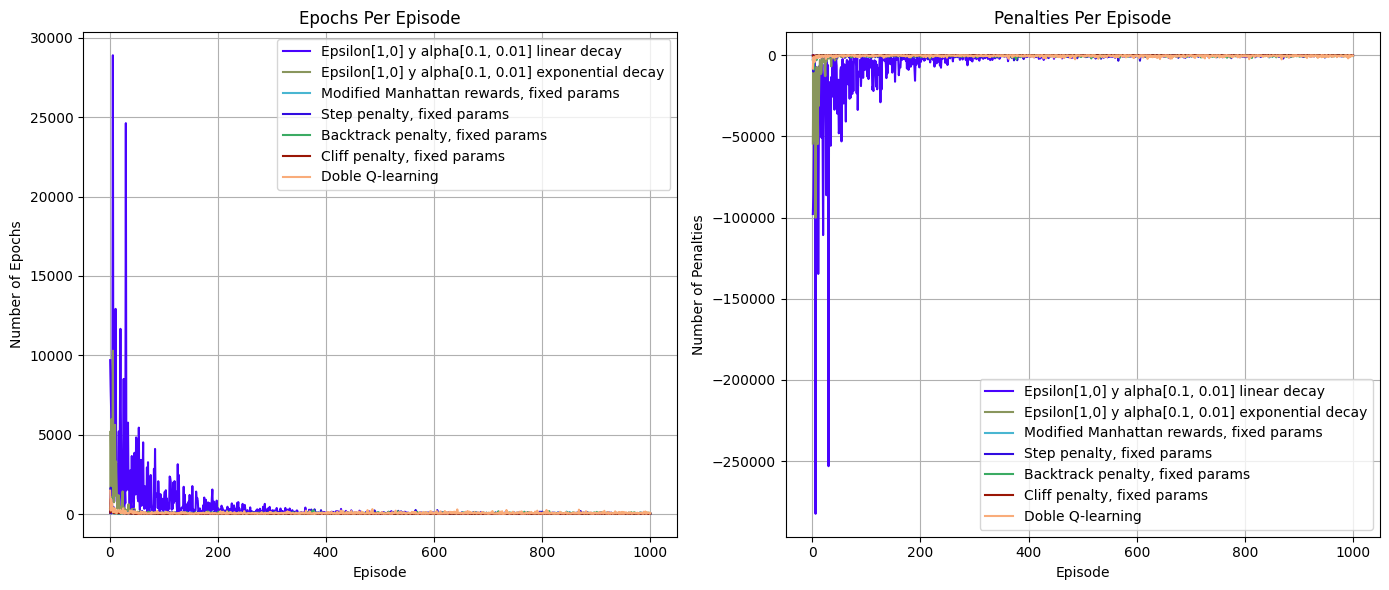

In [41]:
#Gráficas de aprendizaje


import matplotlib.pyplot as plt

method_colors = {method: f"#{random.randint(0, 0xFFFFFF):06x}" for method in methods}

# Create the plots
plt.figure(figsize=(14, 6))

# Plot epochs comparison
plt.subplot(1, 2, 1)
for method, epochs, color in zip(methods, all_epochs, method_colors.values()):
    plt.plot(range(1, len(epochs) + 1), epochs, label=method, color=color)
plt.title("Epochs Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Epochs")
plt.legend()
plt.grid(True)

# Plot penalties comparison
plt.subplot(1, 2, 2)
for method, penalties, color in zip(methods, all_penalties, method_colors.values()):
    plt.plot(range(1, len(penalties) + 1), penalties, label=method, color=color)
plt.title("Penalties Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Penalties")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Vamos a analizar los resultados obtenidos por las gráficas de las distintas métricas:

Empecemos por los resultados obtenido por la primera gráfica que representa el número de pasos del jugador por episodio.
Como podemos observar en las primeras etapas (los episodios iniciales) podemos ver que el número de pasos es considerablemente alto, esto es notable principalmente en la estrategia en la que los parámetro epsilon y alpha van disminuyendo de forma lineal. Esto sugiere que el agente aún no ha aprendido una estrategia eficiente para resolver el problema.
A medida que los episodios progresan, el número de pasos disminuye para todas las configuraciones, lo que indica una mejora en el aprendezaje del agente.
Vemos que todas las estrategias tras 1000 episodios convergen pero viendo la gráfica podriamos concluir que el agente podría terminar de aprender por completo con unos 600 episodios ya que a partir de este momento no se observa ningún despunte de ninguna métrica.

Vamos a analizar algunas de las métricas:
Las estrategias como epsilon y alpha con decaimiento lineal muestran oscilaciones más pronunciadas al inicio, indicando una mayor exploración pero perdiendo eficiencia en las primeras etapas. Podemos observar que también es la que más despuntes tiene a lo largo de la gráfica y la que mas tarde en converger.

Métricas como Cliff penalty parecen estabilizarse más rápidamente, con un descenso más uniforme.


Continuamos analizando los datos mostrados en la segunda gráfica que nos muestran el total de penalizaciones obtenidas por el agente en cada episodio.
Inicialmente podemos volver a observar como el agente tiene una suma considerable de penalizaciones debido a su poco conocimiento sobre la resolución del problema. Como en la gráfica analizada anteriormente este dato es notable principalmente en la que los parámetro epsilon y alpha van disminuyendo de forma lineal.

Tras pocos episodios vemos como el número de penalizaciones acumuladas desciende rápidamente, lo que indica que el agente aprende a evitar las zonas con penalización (precipicio o movimientos desfavorables o repetidos).

Todas las métricas convergen hacia valores similares, lo que indica que las estrategias terminan siendo similares respecto a las penalizaciones que recibe el agente a la hora de resolver el problema tras llevar un tiempo aprendiendo.

Vamos a analizar algunas de las métricas:
En la estrategias que más podemos observar claramente como el agente cada vez es penalizado menos es en la estrategias en la que los parámetros disminuye linealmente. Vemos como inicialmente el agente es penalizado duramente pero esta métrica sufre un descenso un brusco para al final acabar estabilizándose.

Otras estrategias, como Doble Q-learning, muestran un comportamiento más uniforme desde el inicio, lo que podría indicar una mejor estabilidad durante el aprendizaje. 

COMPARACIÓN ENTRE ESTRATEGIAS:
Las estrategias basadas en Epsilon-greedy (lineal y exponencial) parecen enfocarse más en explorar inicialmente, lo que se puede observar claramente en los primeros episodios de ambas gráficas. Esot produce una pérdida inicial en la eficiencia de la búsqueda de la mejor solución para resolver el problema.
Otras métricas como Backtrak penalty y Doble Q-learning desde el principio priorizan una mayor estabilidad en el aprendizaje.

Convergencia:
Todas las métricas desarrolladas hacia al final de los episodios tienden a converger hacia el mismo valor (número pequeño de pasos para resolver el problema o número bajo de penalización a la hora de resolver el mismo).

CONCLUSIONES:
Como hemos podido observar todas las métricas acaban convergiendo a los mismos valores por tanto en todas las métricas en agente acaba aprendiendo como resolver el problema de una forma eficiente.Por tanto, seleccionar una estrategia con respecto a los demás se basará en como queramos que el agente acabe aprendiendo a resolver el problema:
Si queremos que lo haga evitando zonas peligrasas rápidamente usaremos Cliff Penalty.
Si queremos una estabilidad asegurada durante todo el aprendizaje usaremos Doble Q-learning.
Si queremos un aprendizaje más flexible usaremos las métricas basadas en epsilon-greedy.

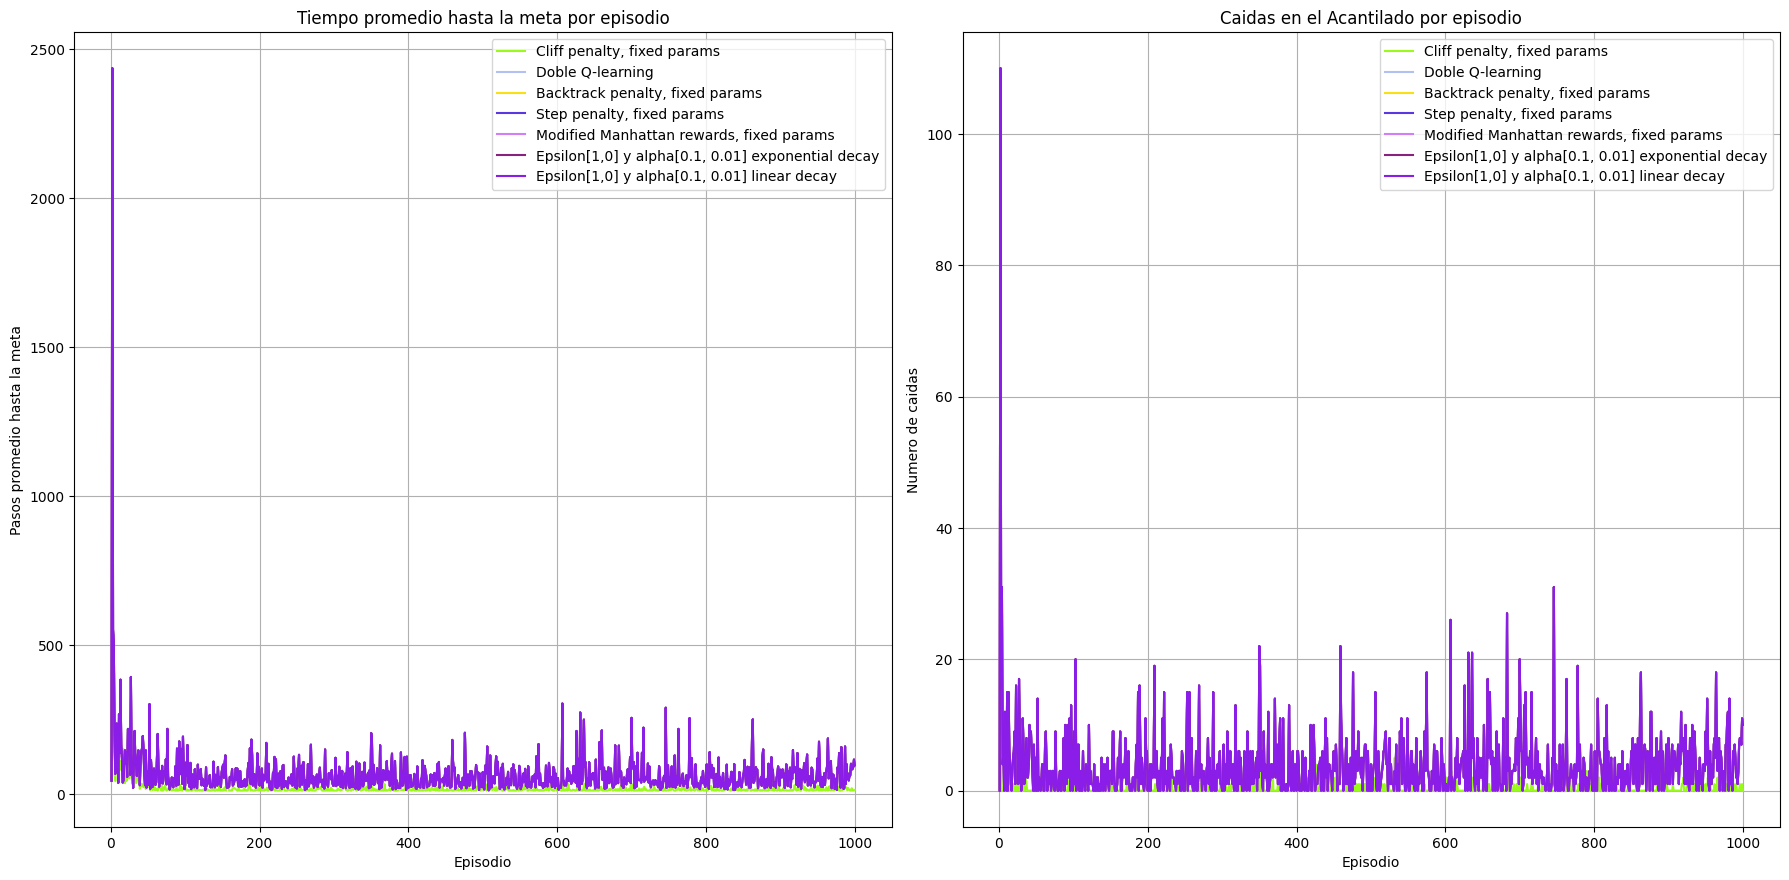

In [28]:
#Tablas de tiempo promedio y caidas en el acantilado

import matplotlib.pyplot as plt

method_colors = {method: f"#{random.randint(0, 0xFFFFFF):06x}" for method in methods}

# Create the plots
plt.figure(figsize=(18, 17))

# Gráfico de Tiempo promedio hasta la meta
plt.subplot(2, 2, 3)
for method, avg_steps, color in zip(methods, all_steps, method_colors.values()):
    plt.plot(range(1, len(avg_steps) + 1), avg_steps, label=method, color=color)
plt.title("Tiempo promedio hasta la meta por episodio")
plt.xlabel("Episodio")
plt.ylabel("Pasos promedio hasta la meta")
plt.legend()
plt.grid(True)

# Gráfico de Caídas en el Acantilado por episodio
plt.subplot(2, 2, 4)
for method, cliff_falls, color in zip(methods, all_cliff_falls, method_colors.values()):
    plt.plot(range(1, len(cliff_falls) + 1), cliff_falls, label=method, color=color)
plt.title("Caidas en el Acantilado por episodio")
plt.xlabel("Episodio")
plt.ylabel("Numero de caidas")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


CONCLUSIONES:


## Actividad para entregar

Configura el aprendizaje por refuerzo para resolver alguno/s de los problemas Toy Text de Gymnasium utilizando distintos valores de configuración de los parámetros y observa qué configuración se comporta mejor.
     
    1. Define las métricas adecuadas para poder evaluar qué tal se comporta el agente entrenado con distintas configuraciones de parámetros.
    2. Realiza una variación dinámica de los valores de los parámetros durante el entrenamiento para que los valores no sean fijos 
    2. Modifica la recompensa por defecto para ver cómo afecta al entrenamiento. Observa cuál es la función de recompensa que se define por defecto (consulta en la documentación de gym). Mejórala reescribiendo el valor de reward y observa cómo afecta la mejora de la función de recompensa en el proceso de aprendizaje. Explica cómo has medido esta mejora.
    4. Realiza pruebas y saca conclusiones claras justificadas con el resumen de resultados. Puedes usar gráficas.  

    